In [3]:
'''
What is the algorythm pattern that we want to follow (same as the one used for cart pole)

env = My_env() # instanciate my environment
done = False # a variable that tell us if an episod is over
state = env.reset() # set the first step at the initial position

#then loop untill an episode is over
while not done:
    a = env.get_action(state) # what is a next step based on the state to perform (based on an Epsilon-greedy method exploitation vs exploration)
    next_state, reward, done, info = env.step(a) # apply the next action and retrieve the next state of the env, 
    #the reward of the action, if the episod is over and additional state information about our env in a dictionnary
    
    state = next_state # then assign the next_state as the current state
'''

'\nWhat is the algorythm pattern that we want to follow (same as the one used for cart pole)\n\nenv = My_env() # instanciate my environment\ndone = False # a variable that tell us if an episod is over\nstate = env.reset() # set the first step at the initial position\n\n#then loop untill an episode is over\nwhile not done:\n    a = env.get_action(state) # what is a next step based on the state to perform (based on an Epsilon-greedy method exploitation vs exploration)\n    next_state, reward, done, info = env.step(a) # apply the next action and retrieve the next state of the env, \n    #the reward of the action, if the episod is over and additional state information about our env in a dictionnary\n    \n    state = next_state # then assign the next_state as the current state\n'

In [4]:
'''
Let's describe our simplified state environment 
we will follow N stock option
for each stock option we know many stocks we own what is the current value of this stocks and how muche money we didn't invest
--> if refers to a vector of 2N+1 dimension
[st1_number, st2_number, st3_number, st1_current_price, st2_current_price, st3_current_price, free_money]

'''

"\nLet's describe our simplified state environment \nwe will follow N stock option\nfor each stock option we know many stocks we own what is the current value of this stocks and how muche money we didn't invest\n--> if refers to a vector of 2N+1 dimension\n[st1_number, st2_number, st3_number, st1_current_price, st2_current_price, st3_current_price, free_money]\n\n"

In [5]:
'''
Let's descirbe the actions
3 possibilities for each stock options : sell, buy, hold
1) sell before buy
We will use the round robin to simplify the way we sell and dispatch our freem_money
buy 1 of each stock option untill we spent the available amount
'''

"\nLet's descirbe the actions\n3 possibilities for each stock options : sell, buy, hold\n1) sell before buy\nWe will use the round robin to simplify the way we sell and dispatch our freem_money\nbuy 1 of each stock option untill we spent the available amount\n"

In [6]:
'''
Let's describe the reward we get 
if s : the stock options
p : the current price
c : free cash available
then aou current money is sTp + c
the reward will be s'Tp' + c' - (sTp + c)
'''

"\nLet's describe the reward we get \nif s : the stock options\np : the current price\nc : free cash available\nthen aou current money is sTp + c\nthe reward will be s'Tp' + c' - (sTp + c)\n"

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

from sklearn.preprocessing import StandardScaler

In [33]:
#Let's use AAPL (Apple), MSI (Motoral), SBUX (starbucks)
def get_data():
    df = pd.read_csv('aapl_msi_sbux.csv')
    return df.values

def get_scaler(env):
    states = []
    for _ in range(env.n_step - 1):
        a = np.random.choice(env.action_space)
        state, reward, done, info = env.step(a)
        states.append(state)
    
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [10]:
class LinearModel:
    
    '''A linear regression model'''
    def __init__(self, input_dim, n_action):
        self.W = np.random.randn(input_dim,n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)
        
        # momentum terms
        self.vW = 0
        self.vb = 0
        
        self.losses = []
        
    def predict(self, X):
        assert(len(X.shape)) == 2
        return X.dot(self.W) + self.b
    
    def sgd(self, X,Y, learning_rate=0.01, momentum=0.9):
        assert(len(X.shape)) == 2
        
        num_values = np.prod(Y.shape)
        
        #calculate the gradient descent for one step
        Yhat = self.predict(X)
        gW = 2 * X.T.dot(Yhat - Y) / num_values
        gb = 2 * (Yhat - Y).sum(axis = 0) / num_values
        
        #calculate the momentum
        self.vW = momentum * self.vW - learning_rate * gW
        self.vb = momentum * self.vb - learning_rate * gb
        
        #update params
        self.W += self.vW
        self.b += self.vb
        
        mse = np.mean((Yhat - Y)**2)
        self.losses.append(mse)
    
    def load_weights(self, filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']
        
    def save_weights(self, filepath):
        np.savez(filepath, W=self.W, b=self.b)

In [30]:
class MultiStockEnv:
    
    def __init__(self, data, initial_investment = 20000):
        
        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape
        
        #instance attributes
        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        
        self.action_space = np.arange(3**self.n_stock)
        
        #0 : sell
        #1 : do nothing
        #2 : buy
        self.action_list = list(map(list, itertools.product([0,1,2], repeat=self.n_stock)))
        
        self.state_dim = self.n_stock * 2 + 1
        
        self.reset()
        
    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()
    
    def step(self, action):
        assert action in self.action_space
        
        prev_val = self._get_val()
        
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]
        
        self._trade(action)
        
        cur_val = self._get_val()
        
        reward = cur_val - prev_val
        
        done = self.cur_step == self.n_step - 1
        
        info = {'cur_val' : cur_val}
        
        return self._get_obs(), reward, done, info
    
    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2*self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs
    
    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand
    
    def _trade(self, action):
        action_vec = self.action_list[action]
        
        sell_index = []
        buy_index = []
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a==2:
                buy_index.append(i)
                
        if sell_index:
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0
        if buy_index:
            can_buy = True
            while can_buy: 
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False
    
        

In [39]:
class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size,action_size)
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis = 1)
            
        target_full = self.model.predict(state)
        target_full[0, action] = target
        
        self.model.sgd(state, target_full)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def load(self, name):
        self.model.load_weights(name)
        
    def save(self, name):
        self.model.save_weights(name)

        
    

In [42]:
def play_one_episode(agent, env, is_train, scaler):
    state = env.reset()
    state = scaler.transform([state])
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if is_train == 'train':
            agent.train(state, action, reward, next_state, done)
        state = next_state
    
    return info['cur_val']


def main(mod):
    models_folder = 'linear_rl_trader_models'
    rewards_folder = 'linear_rl_trader_rewards'
    num_episodes = 2000
    batch_size = 32
    initial_investment = 20000
    
    
    #parser = argparse.ArgumentParser()
    #parser.add_argument('-m', '--mode', type=str, required = True, 
                       #help='either "train or test"')
    #args = parser.parse_args()
    
    maybe_make_dir(models_folder)
    maybe_make_dir(rewards_folder)
    
    data = get_data()
    n_timesteps, n_stocks = data.shape
    
    n_train = n_timesteps // 2
    
    train_data = data[:n_train]
    test_data = data[n_train:]
    
    env = MultiStockEnv(train_data, initial_investment)
    state_size = env.state_dim
    action_size = len(env.action_space)
    agent = DQNAgent(state_size, action_size)
    scaler = get_scaler(env)
    
    portfolio_value = []
    
    #if args.mode == 'test'or mod == 'test':
    if mod == 'test':
        with open(f'{models_folder}/scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
    
        env = MultiStockEnv(test_data, initial_investment)
        
        agent.epsilon = 0.01
        
        agent.load(f'{models_folder}/linear.npz')
        
    for e in range(num_episodes):
        t0 = datetime.now()
        val = play_one_episode(agent, env, mod, scaler)
        dt = datetime.now() - t0
        print(f"episode:  {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
        portfolio_value.append(val)
        
    #if args.mode == 'train' or mod == 'train':
    if mod == 'train':
        agent.save(f'{models_folder}/linear.npz')
        
        with open(f"{models_folder}/scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)
        
        plt.plot(agent.model.losses)
        plt.show()
        
    np.save(f"{rewards_folder}/{mod}.npy", portfolio_value)

episode:  1/2000, episode end value: 28649.08, duration: 0:00:00.199498
episode:  2/2000, episode end value: 27907.83, duration: 0:00:00.154557
episode:  3/2000, episode end value: 33759.35, duration: 0:00:00.165557
episode:  4/2000, episode end value: 33129.19, duration: 0:00:00.163593
episode:  5/2000, episode end value: 32594.81, duration: 0:00:00.190509
episode:  6/2000, episode end value: 34130.42, duration: 0:00:00.190527
episode:  7/2000, episode end value: 33157.36, duration: 0:00:00.255104
episode:  8/2000, episode end value: 33750.77, duration: 0:00:00.228388
episode:  9/2000, episode end value: 33278.17, duration: 0:00:00.248337
episode:  10/2000, episode end value: 33871.15, duration: 0:00:00.246698
episode:  11/2000, episode end value: 34478.11, duration: 0:00:00.250332
episode:  12/2000, episode end value: 41660.65, duration: 0:00:00.250333
episode:  13/2000, episode end value: 46534.56, duration: 0:00:00.251872
episode:  14/2000, episode end value: 43314.92, duration: 0:

episode:  114/2000, episode end value: 40321.89, duration: 0:00:00.180475
episode:  115/2000, episode end value: 33592.42, duration: 0:00:00.204489
episode:  116/2000, episode end value: 42758.70, duration: 0:00:00.168539
episode:  117/2000, episode end value: 40619.51, duration: 0:00:00.177533
episode:  118/2000, episode end value: 28904.35, duration: 0:00:00.232373
episode:  119/2000, episode end value: 41581.93, duration: 0:00:00.160611
episode:  120/2000, episode end value: 41487.08, duration: 0:00:00.186478
episode:  121/2000, episode end value: 42988.35, duration: 0:00:00.192588
episode:  122/2000, episode end value: 41416.66, duration: 0:00:00.167033
episode:  123/2000, episode end value: 49616.22, duration: 0:00:00.245850
episode:  124/2000, episode end value: 39369.59, duration: 0:00:00.226433
episode:  125/2000, episode end value: 48164.15, duration: 0:00:00.192451
episode:  126/2000, episode end value: 40296.93, duration: 0:00:00.176526
episode:  127/2000, episode end value:

episode:  225/2000, episode end value: 49315.64, duration: 0:00:00.240358
episode:  226/2000, episode end value: 49438.17, duration: 0:00:00.239361
episode:  227/2000, episode end value: 38871.02, duration: 0:00:00.245104
episode:  228/2000, episode end value: 47958.06, duration: 0:00:00.178801
episode:  229/2000, episode end value: 47305.73, duration: 0:00:00.215425
episode:  230/2000, episode end value: 35355.62, duration: 0:00:00.259760
episode:  231/2000, episode end value: 52823.27, duration: 0:00:00.222408
episode:  232/2000, episode end value: 47997.17, duration: 0:00:00.252328
episode:  233/2000, episode end value: 40619.96, duration: 0:00:00.240359
episode:  234/2000, episode end value: 51461.45, duration: 0:00:00.273269
episode:  235/2000, episode end value: 55166.21, duration: 0:00:00.249336
episode:  236/2000, episode end value: 38204.38, duration: 0:00:00.291095
episode:  237/2000, episode end value: 49399.63, duration: 0:00:00.337101
episode:  238/2000, episode end value:

episode:  336/2000, episode end value: 53035.22, duration: 0:00:00.396520
episode:  337/2000, episode end value: 47970.57, duration: 0:00:00.363029
episode:  338/2000, episode end value: 43011.29, duration: 0:00:00.214431
episode:  339/2000, episode end value: 52353.63, duration: 0:00:00.295211
episode:  340/2000, episode end value: 57030.02, duration: 0:00:00.416795
episode:  341/2000, episode end value: 34373.65, duration: 0:00:00.276727
episode:  342/2000, episode end value: 42958.27, duration: 0:00:00.285242
episode:  343/2000, episode end value: 43082.87, duration: 0:00:00.377993
episode:  344/2000, episode end value: 46049.60, duration: 0:00:00.419808
episode:  345/2000, episode end value: 45402.16, duration: 0:00:00.396563
episode:  346/2000, episode end value: 41203.44, duration: 0:00:00.392297
episode:  347/2000, episode end value: 44762.50, duration: 0:00:00.432846
episode:  348/2000, episode end value: 41747.10, duration: 0:00:00.393947
episode:  349/2000, episode end value:

episode:  448/2000, episode end value: 44467.40, duration: 0:00:00.179687
episode:  449/2000, episode end value: 52744.73, duration: 0:00:00.229192
episode:  450/2000, episode end value: 54659.48, duration: 0:00:00.185540
episode:  451/2000, episode end value: 49490.39, duration: 0:00:00.164993
episode:  452/2000, episode end value: 51797.21, duration: 0:00:00.162041
episode:  453/2000, episode end value: 39011.36, duration: 0:00:00.167552
episode:  454/2000, episode end value: 48539.75, duration: 0:00:00.237371
episode:  455/2000, episode end value: 47801.46, duration: 0:00:00.189561
episode:  456/2000, episode end value: 41539.34, duration: 0:00:00.182540
episode:  457/2000, episode end value: 51540.65, duration: 0:00:00.184526
episode:  458/2000, episode end value: 39472.93, duration: 0:00:00.172447
episode:  459/2000, episode end value: 50451.04, duration: 0:00:00.195490
episode:  460/2000, episode end value: 51179.08, duration: 0:00:00.167411
episode:  461/2000, episode end value:

episode:  559/2000, episode end value: 48316.13, duration: 0:00:00.280249
episode:  560/2000, episode end value: 48613.60, duration: 0:00:00.267638
episode:  561/2000, episode end value: 38740.24, duration: 0:00:00.167570
episode:  562/2000, episode end value: 46183.72, duration: 0:00:00.169837
episode:  563/2000, episode end value: 53189.06, duration: 0:00:00.181542
episode:  564/2000, episode end value: 47061.68, duration: 0:00:00.192526
episode:  565/2000, episode end value: 45621.58, duration: 0:00:00.152592
episode:  566/2000, episode end value: 50602.14, duration: 0:00:00.180518
episode:  567/2000, episode end value: 51564.82, duration: 0:00:00.182513
episode:  568/2000, episode end value: 50668.16, duration: 0:00:00.169280
episode:  569/2000, episode end value: 53105.66, duration: 0:00:00.163553
episode:  570/2000, episode end value: 52176.99, duration: 0:00:00.195973
episode:  571/2000, episode end value: 38348.70, duration: 0:00:00.197726
episode:  572/2000, episode end value:

episode:  670/2000, episode end value: 50692.70, duration: 0:00:00.228436
episode:  671/2000, episode end value: 48464.88, duration: 0:00:00.230351
episode:  672/2000, episode end value: 63202.53, duration: 0:00:00.354061
episode:  673/2000, episode end value: 46618.98, duration: 0:00:00.253431
episode:  674/2000, episode end value: 63118.94, duration: 0:00:00.272446
episode:  675/2000, episode end value: 75696.18, duration: 0:00:00.398972
episode:  676/2000, episode end value: 43891.90, duration: 0:00:00.268247
episode:  677/2000, episode end value: 39414.36, duration: 0:00:00.219996
episode:  678/2000, episode end value: 58631.15, duration: 0:00:00.412902
episode:  679/2000, episode end value: 53304.42, duration: 0:00:00.353064
episode:  680/2000, episode end value: 43452.41, duration: 0:00:00.341623
episode:  681/2000, episode end value: 60579.10, duration: 0:00:00.295176
episode:  682/2000, episode end value: 65277.07, duration: 0:00:00.405914
episode:  683/2000, episode end value:

episode:  781/2000, episode end value: 49236.63, duration: 0:00:00.279254
episode:  782/2000, episode end value: 56907.58, duration: 0:00:00.391505
episode:  783/2000, episode end value: 65794.01, duration: 0:00:00.313181
episode:  784/2000, episode end value: 41953.92, duration: 0:00:00.310201
episode:  785/2000, episode end value: 54087.91, duration: 0:00:00.393564
episode:  786/2000, episode end value: 53579.59, duration: 0:00:00.746012
episode:  787/2000, episode end value: 67003.64, duration: 0:00:00.980381
episode:  788/2000, episode end value: 48279.14, duration: 0:00:00.483784
episode:  789/2000, episode end value: 49524.44, duration: 0:00:00.313184
episode:  790/2000, episode end value: 53770.11, duration: 0:00:00.342107
episode:  791/2000, episode end value: 48150.04, duration: 0:00:00.304187
episode:  792/2000, episode end value: 49957.65, duration: 0:00:00.324136
episode:  793/2000, episode end value: 47102.34, duration: 0:00:00.503015
episode:  794/2000, episode end value:

episode:  893/2000, episode end value: 42774.58, duration: 0:00:00.218443
episode:  894/2000, episode end value: 53855.76, duration: 0:00:00.200463
episode:  895/2000, episode end value: 57445.67, duration: 0:00:00.216423
episode:  896/2000, episode end value: 40200.78, duration: 0:00:00.215429
episode:  897/2000, episode end value: 43509.14, duration: 0:00:00.225397
episode:  898/2000, episode end value: 29327.89, duration: 0:00:00.179568
episode:  899/2000, episode end value: 70215.66, duration: 0:00:00.247323
episode:  900/2000, episode end value: 48387.37, duration: 0:00:00.261332
episode:  901/2000, episode end value: 54418.33, duration: 0:00:00.222545
episode:  902/2000, episode end value: 52431.11, duration: 0:00:00.230405
episode:  903/2000, episode end value: 51200.41, duration: 0:00:00.218952
episode:  904/2000, episode end value: 53167.50, duration: 0:00:00.230393
episode:  905/2000, episode end value: 49007.66, duration: 0:00:00.216117
episode:  906/2000, episode end value:

episode:  1004/2000, episode end value: 73611.14, duration: 0:00:00.388917
episode:  1005/2000, episode end value: 46851.33, duration: 0:00:00.325134
episode:  1006/2000, episode end value: 55389.66, duration: 0:00:00.304190
episode:  1007/2000, episode end value: 51806.81, duration: 0:00:00.253827
episode:  1008/2000, episode end value: 54319.60, duration: 0:00:00.270214
episode:  1009/2000, episode end value: 48307.60, duration: 0:00:00.256313
episode:  1010/2000, episode end value: 43482.92, duration: 0:00:00.769876
episode:  1011/2000, episode end value: 53996.91, duration: 0:00:00.424592
episode:  1012/2000, episode end value: 42151.43, duration: 0:00:00.255318
episode:  1013/2000, episode end value: 52719.52, duration: 0:00:00.225404
episode:  1014/2000, episode end value: 55187.19, duration: 0:00:00.196473
episode:  1015/2000, episode end value: 54446.66, duration: 0:00:00.205484
episode:  1016/2000, episode end value: 40919.01, duration: 0:00:00.232420
episode:  1017/2000, epis

episode:  1114/2000, episode end value: 51802.86, duration: 0:00:00.218415
episode:  1115/2000, episode end value: 52011.59, duration: 0:00:00.208450
episode:  1116/2000, episode end value: 48068.00, duration: 0:00:00.267131
episode:  1117/2000, episode end value: 48023.14, duration: 0:00:00.207035
episode:  1118/2000, episode end value: 63812.79, duration: 0:00:00.242733
episode:  1119/2000, episode end value: 30709.65, duration: 0:00:00.414778
episode:  1120/2000, episode end value: 44258.77, duration: 0:00:00.326959
episode:  1121/2000, episode end value: 42877.96, duration: 0:00:00.268583
episode:  1122/2000, episode end value: 50415.08, duration: 0:00:00.273775
episode:  1123/2000, episode end value: 48369.87, duration: 0:00:00.753988
episode:  1124/2000, episode end value: 52805.95, duration: 0:00:00.356054
episode:  1125/2000, episode end value: 51999.87, duration: 0:00:00.275266
episode:  1126/2000, episode end value: 62954.72, duration: 0:00:00.341088
episode:  1127/2000, epis

episode:  1224/2000, episode end value: 65153.36, duration: 0:00:00.400796
episode:  1225/2000, episode end value: 56809.15, duration: 0:00:00.271324
episode:  1226/2000, episode end value: 60809.26, duration: 0:00:00.320169
episode:  1227/2000, episode end value: 69252.80, duration: 0:00:00.360039
episode:  1228/2000, episode end value: 68496.71, duration: 0:00:00.366364
episode:  1229/2000, episode end value: 59222.85, duration: 0:00:00.476729
episode:  1230/2000, episode end value: 54459.58, duration: 0:00:00.335131
episode:  1231/2000, episode end value: 52577.22, duration: 0:00:00.266292
episode:  1232/2000, episode end value: 58693.38, duration: 0:00:00.310170
episode:  1233/2000, episode end value: 54825.02, duration: 0:00:00.481246
episode:  1234/2000, episode end value: 58351.74, duration: 0:00:00.422635
episode:  1235/2000, episode end value: 52902.03, duration: 0:00:00.623198
episode:  1236/2000, episode end value: 50141.47, duration: 0:00:00.307180
episode:  1237/2000, epis

episode:  1334/2000, episode end value: 47379.84, duration: 0:00:00.390990
episode:  1335/2000, episode end value: 47030.96, duration: 0:00:00.341303
episode:  1336/2000, episode end value: 42479.64, duration: 0:00:00.287835
episode:  1337/2000, episode end value: 43774.85, duration: 0:00:00.245351
episode:  1338/2000, episode end value: 57639.98, duration: 0:00:00.335101
episode:  1339/2000, episode end value: 50297.52, duration: 0:00:00.265292
episode:  1340/2000, episode end value: 43613.97, duration: 0:00:00.304455
episode:  1341/2000, episode end value: 47454.54, duration: 0:00:00.201482
episode:  1342/2000, episode end value: 44462.27, duration: 0:00:00.327119
episode:  1343/2000, episode end value: 58134.05, duration: 0:00:00.199467
episode:  1344/2000, episode end value: 55857.70, duration: 0:00:00.249902
episode:  1345/2000, episode end value: 48361.87, duration: 0:00:00.264289
episode:  1346/2000, episode end value: 60441.66, duration: 0:00:00.234374
episode:  1347/2000, epis

episode:  1445/2000, episode end value: 64169.92, duration: 0:00:00.200210
episode:  1446/2000, episode end value: 41616.11, duration: 0:00:00.290735
episode:  1447/2000, episode end value: 57833.07, duration: 0:00:00.215431
episode:  1448/2000, episode end value: 51052.89, duration: 0:00:00.241363
episode:  1449/2000, episode end value: 44983.42, duration: 0:00:00.191489
episode:  1450/2000, episode end value: 50593.52, duration: 0:00:00.183600
episode:  1451/2000, episode end value: 51540.27, duration: 0:00:00.183579
episode:  1452/2000, episode end value: 55813.08, duration: 0:00:00.224636
episode:  1453/2000, episode end value: 53317.82, duration: 0:00:00.222064
episode:  1454/2000, episode end value: 59736.39, duration: 0:00:00.257730
episode:  1455/2000, episode end value: 57697.75, duration: 0:00:00.237858
episode:  1456/2000, episode end value: 55616.30, duration: 0:00:00.181482
episode:  1457/2000, episode end value: 53129.72, duration: 0:00:00.193600
episode:  1458/2000, epis

episode:  1555/2000, episode end value: 46328.17, duration: 0:00:00.282246
episode:  1556/2000, episode end value: 51227.29, duration: 0:00:00.387964
episode:  1557/2000, episode end value: 55964.63, duration: 0:00:00.414893
episode:  1558/2000, episode end value: 47125.85, duration: 0:00:00.281191
episode:  1559/2000, episode end value: 52304.89, duration: 0:00:00.234887
episode:  1560/2000, episode end value: 47755.59, duration: 0:00:00.255317
episode:  1561/2000, episode end value: 37374.63, duration: 0:00:00.263297
episode:  1562/2000, episode end value: 41150.81, duration: 0:00:00.354057
episode:  1563/2000, episode end value: 55399.53, duration: 0:00:00.307191
episode:  1564/2000, episode end value: 55701.75, duration: 0:00:00.264323
episode:  1565/2000, episode end value: 54144.33, duration: 0:00:00.254334
episode:  1566/2000, episode end value: 53435.95, duration: 0:00:00.268281
episode:  1567/2000, episode end value: 55553.01, duration: 0:00:00.341092
episode:  1568/2000, epis

episode:  1665/2000, episode end value: 58910.36, duration: 0:00:00.356143
episode:  1666/2000, episode end value: 55185.31, duration: 0:00:00.520382
episode:  1667/2000, episode end value: 66341.37, duration: 0:00:00.291028
episode:  1668/2000, episode end value: 45234.77, duration: 0:00:00.223966
episode:  1669/2000, episode end value: 67134.81, duration: 0:00:00.215960
episode:  1670/2000, episode end value: 44339.35, duration: 0:00:00.196292
episode:  1671/2000, episode end value: 46500.75, duration: 0:00:00.231443
episode:  1672/2000, episode end value: 35603.87, duration: 0:00:00.343116
episode:  1673/2000, episode end value: 53192.29, duration: 0:00:00.258314
episode:  1674/2000, episode end value: 44723.60, duration: 0:00:00.255442
episode:  1675/2000, episode end value: 64633.62, duration: 0:00:00.208444
episode:  1676/2000, episode end value: 42824.23, duration: 0:00:00.202728
episode:  1677/2000, episode end value: 51308.96, duration: 0:00:00.210181
episode:  1678/2000, epis

episode:  1776/2000, episode end value: 44258.33, duration: 0:00:00.232895
episode:  1777/2000, episode end value: 33726.08, duration: 0:00:00.215418
episode:  1778/2000, episode end value: 52748.84, duration: 0:00:00.269624
episode:  1779/2000, episode end value: 51929.50, duration: 0:00:00.201461
episode:  1780/2000, episode end value: 31790.88, duration: 0:00:00.205452
episode:  1781/2000, episode end value: 52298.59, duration: 0:00:00.199472
episode:  1782/2000, episode end value: 58680.98, duration: 0:00:00.194511
episode:  1783/2000, episode end value: 39621.47, duration: 0:00:00.201472
episode:  1784/2000, episode end value: 66476.73, duration: 0:00:00.201461
episode:  1785/2000, episode end value: 37043.60, duration: 0:00:00.181280
episode:  1786/2000, episode end value: 48369.66, duration: 0:00:00.207415
episode:  1787/2000, episode end value: 40187.02, duration: 0:00:00.227429
episode:  1788/2000, episode end value: 53847.57, duration: 0:00:00.223701
episode:  1789/2000, epis

episode:  1886/2000, episode end value: 63036.55, duration: 0:00:00.248739
episode:  1887/2000, episode end value: 62402.56, duration: 0:00:00.211945
episode:  1888/2000, episode end value: 49911.80, duration: 0:00:00.232379
episode:  1889/2000, episode end value: 55669.20, duration: 0:00:00.246342
episode:  1890/2000, episode end value: 69802.33, duration: 0:00:00.338635
episode:  1891/2000, episode end value: 60311.59, duration: 0:00:00.346155
episode:  1892/2000, episode end value: 56299.96, duration: 0:00:00.384881
episode:  1893/2000, episode end value: 46763.24, duration: 0:00:00.281214
episode:  1894/2000, episode end value: 54962.15, duration: 0:00:00.252362
episode:  1895/2000, episode end value: 57975.25, duration: 0:00:00.263414
episode:  1896/2000, episode end value: 69867.21, duration: 0:00:00.218413
episode:  1897/2000, episode end value: 47964.76, duration: 0:00:00.277291
episode:  1898/2000, episode end value: 49963.01, duration: 0:00:00.239532
episode:  1899/2000, epis

episode:  1996/2000, episode end value: 67060.84, duration: 0:00:00.470744
episode:  1997/2000, episode end value: 61740.89, duration: 0:00:00.353576
episode:  1998/2000, episode end value: 51719.42, duration: 0:00:00.363828
episode:  1999/2000, episode end value: 59815.57, duration: 0:00:00.274722
episode:  2000/2000, episode end value: 55204.85, duration: 0:00:00.315190


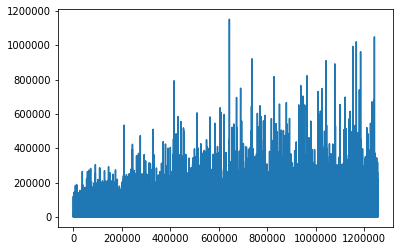

NameError: name 'args' is not defined

In [44]:
main('train')